## Title

**Authors:** <br>
Björn Hahn (941084) <br>
Domenico Ferraro (941398)<br>
Justus Raabe (940919) <br>
Lisa Sachau (941367)

#### Imported Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions as func

#### Load Data
A basic code block to load image data from relative paths and extracting neccesary parameters for further data preperation. <br>
Afterwards **func.read_images** transform every image data by using the given dictionary **input_shape** to fit predefined conditions. <br>
Lastly the created lists are rewritten into Numpy arrays via **images_to_array** for the following data processing.


['./Fotos_einfach\\lion\\l1.jpeg', './Fotos_einfach\\lion\\l10.jpeg', './Fotos_einfach\\lion\\l2.jpeg', './Fotos_einfach\\lion\\l3.jpeg', './Fotos_einfach\\lion\\l4.jpeg', './Fotos_einfach\\lion\\l5.jpeg', './Fotos_einfach\\lion\\l6.jpeg', './Fotos_einfach\\lion\\l7.jpeg', './Fotos_einfach\\lion\\l8.jpeg', './Fotos_einfach\\lion\\l9.jpeg', './Fotos_einfach\\manul\\m1.jpg', './Fotos_einfach\\manul\\m10.jpg', './Fotos_einfach\\manul\\m2.jpg', './Fotos_einfach\\manul\\m3.jpg', './Fotos_einfach\\manul\\m4.jpg', './Fotos_einfach\\manul\\m5.jpg', './Fotos_einfach\\manul\\m6.jpg', './Fotos_einfach\\manul\\m7.jpg', './Fotos_einfach\\manul\\m8.jpg', './Fotos_einfach\\manul\\m9.JPG', './Fotos_einfach\\sand cat\\s1.jpg', './Fotos_einfach\\sand cat\\s10.jpg', './Fotos_einfach\\sand cat\\s2.jpg', './Fotos_einfach\\sand cat\\s3.jpg', './Fotos_einfach\\sand cat\\s4.jpg', './Fotos_einfach\\sand cat\\s5.jpg', './Fotos_einfach\\sand cat\\s6.jpg', './Fotos_einfach\\sand cat\\s7.jpg', './Fotos_einfach\\sa

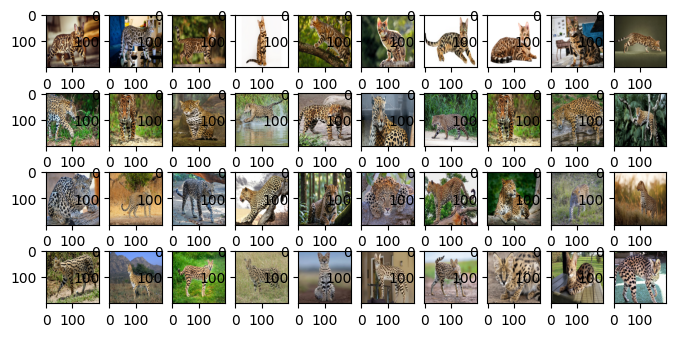

In [2]:
# Get file names
folder_e = './Fotos_einfach'
folder_h = './Fotos_schwierig'

categories_e, image_names_e, labels_e = func.get_filenames_labels(folder_e)
categories_h, image_names_h, labels_h = func.get_filenames_labels(folder_h)
print(image_names_e)
print(labels_e)
print(categories_e)
print(image_names_h)
print(labels_h)
print(categories_h)
# Load images
input_shape = {
    "height": 200,
    "width": 200,
    "channels": 3
}
images_e = func.read_images(image_names_e, height=input_shape["height"], width=input_shape["width"])
images_h = func.read_images(image_names_h, height=input_shape["height"], width=input_shape["width"])
# Convert images to array
aimages_e = func.images_to_array(images_e)
aimages_h = func.images_to_array(images_h)
print(f'Shape of images array: {aimages_e.shape}')
# Plot images array
fig = plt.figure(figsize=(8, 8))
rows, columns = 8, 10
for i in range(aimages_h.shape[0]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aimages_h[i, ...])
plt.show()


#### Data Augmentation
We are using data augmentation to increase our training data by rotating existing images from our **aimage_e and aimage_h** arrays. <br>
we are using the variables **aug_images and aug_labels** to create new lists that, in addition to our existing image data, will contain our newly rotated images and their labels. <br>
Followed by rewriting the newly acquired data into new arrays and plotting them for visual validation.


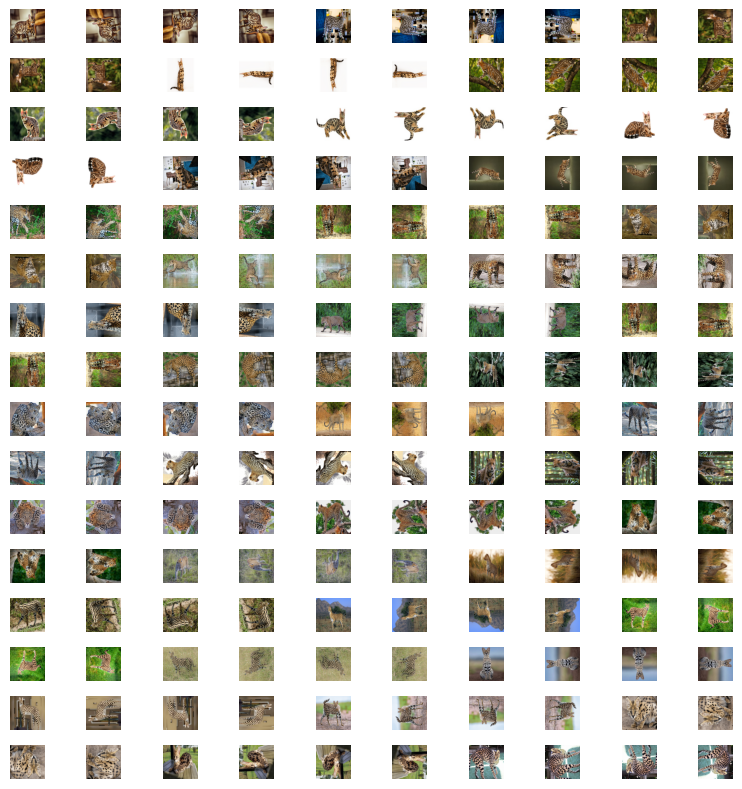

['bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopa

In [3]:
def augment_images(images, labels):
    aug_images = []
    aug_labels = []
    for i, row in enumerate(images):
        # Original
        aug_images.append(images[i])
        aug_labels.append(labels[i])
        
        # 90-degree rotation (to the right)
        aug_images.append(np.rot90(row, k=1))
        aug_labels.append(labels[i])
        
        # 180-degree rotation (upside down)
        aug_images.append(np.rot90(row, k=2))
        aug_labels.append(labels[i])
        
        # 270-degree rotation (to the left)
        aug_images.append(np.rot90(row, k=3))
        aug_labels.append(labels[i])
    
    return aug_images, aug_labels

# Apply augmentation to easy images
a_images_e, a_labels_e = augment_images(aimages_e, labels_e)
aug_images_e = func.images_to_array(a_images_e)
aug_labels_e = func.images_to_array(a_labels_e)

# Apply augmentation to difficult images
a_images_h, a_labels_h = augment_images(aimages_h, labels_h)
aug_images_h = func.images_to_array(a_images_h)
aug_labels_h = func.images_to_array(a_labels_h)

# Visualize the augmented images with dynamic grid
total_images = aug_images_h.shape[0]
columns = 10
rows = int(np.ceil(total_images / columns))  # Dynamically calculate the number of rows

fig = plt.figure(figsize=(8, 8))
for i in range(total_images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aug_images_h[i, ...])
    plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

# Print augmented labels and shape
print(aug_labels_h)
print(aug_labels_h.shape)
print(categories_h)

#### Encode Labels
Using our selfmade OneHotEncoder to convert categorical data into a binary format using a matrix.

In [4]:
y_e = func.ownOneHotEncoder(aug_labels_e, categories_e)
categorie_encoded_e = func.ownOneHotEncoder(categories_e, categories_e)
y_h = func.ownOneHotEncoder(aug_labels_h, categories_h)
categorie_encoded_h = func.ownOneHotEncoder(categories_h, categories_h)

#### Training and Test-Split with K-Fold (vielleicht K-Fold auch später, unsicher bei Reihenfolge tbh)

[0 1 2 3]
[0 1 2 3]


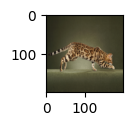

[1 0 0 0]
[1 0 0 0]


In [5]:
data_e = aug_images_e
data_h = aug_images_h
k = 5
image_folds_e, y_folds_e = func.stratified_k_fold(data_e, y_e, k)
image_folds_h, y_folds_h = func.stratified_k_fold(data_h, y_h, k)
fig = plt.figure(figsize=(2, 1))
plt.imshow(image_folds_e[3][2])
plt.imshow(image_folds_h[3][2])
plt.show()
print(y_folds_e[3][2])
print(y_folds_h[3][2])

#### Build Model

model training for our first "easy" data set where as our validation data equals the latest created k-fold, the test data equals the penultimate fold and our training data equals all folds not used for validation or testing. <br>
to create our train data we are concatenating every available fold, not used for validating or testing, via the inbuilt Numpy function. <br>
we are building the model in an iterative way using the k-fold method. <br>
Additionaly we are saving every value for the maximum of accuracy and val_accuracy for each iteration of the model into their respective lists for future visualisation.

In [6]:
epoch = 100
accuracy_e = []
val_accuracy_e = []
eval_accuracy_e = []
prediction_e = []
for i in range(k):
    fold_x_train = np.concatenate([image_folds_e[j] for j in range(k) if j != i and (j != i-1 if i-1 != -1 else j != k-1)], axis=0)
    fold_y_train = np.concatenate([y_folds_e[j] for j in range(k) if j != i and (j != i-1 if i-1 != -1 else j != k-1)], axis=0)
    fold_x_val = image_folds_e[i]
    fold_y_val = y_folds_e[i]
    fold_x_test = image_folds_e[i-1]
    fold_y_test = y_folds_e[i-1]
    history, evaluate_accuracy, cnn_model = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, fold_x_test, fold_y_test, input_shape)
    yhat = cnn_model.predict(fold_x_test)
    yhat = np.argmax(yhat, axis=1)
    y = np.argmax(fold_y_test, axis=1)
    accuracy_e.append(max(history.history['accuracy']))
    val_accuracy_e.append(max(history.history['val_accuracy']))
    eval_accuracy_e.append(evaluate_accuracy)
    prediction_e.append(round(func.accuracy(y, yhat)*100, 2))
print(accuracy_e)
print(val_accuracy_e)
print(eval_accuracy_e)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2930 - loss: 77.1260 - val_accuracy: 0.2500 - val_loss: 33.4951
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2721 - loss: 93.2150 - val_accuracy: 0.1250 - val_loss: 3.4651
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3438 - loss: 18.0524 - val_accuracy: 0.2188 - val_loss: 2.9377
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2383 - loss: 13.1878 - val_accuracy: 0.1562 - val_loss: 2.5004
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2799 - loss: 12.8400 - val_accuracy: 0.2188 - val_loss: 1.9808
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3268 - loss: 7.7006 - val_accuracy: 0.1562 - val_loss: 2.0991
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3750 - loss: 5.7296 - val_accuracy: 0.2812 - val_loss: 1.7085
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3815 - loss: 5.2613 - val_accuracy: 0.3125 - val_loss: 1.4251
Ep

Plotting of Accuracy and Loss

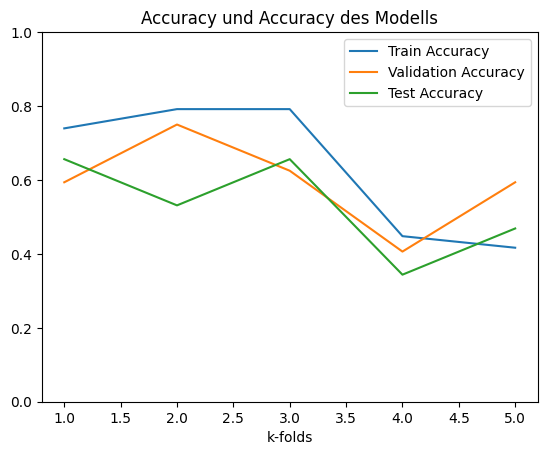

In [7]:
# noch zu überarbeiten
y_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.plot(range(1, k+1), accuracy_e)
plt.plot(range(1, k+1), val_accuracy_e)
plt.plot(range(1, k+1), eval_accuracy_e)
plt.title('Accuracy und Accuracy des Modells')
plt.xlabel('k-folds')
plt.yticks(y_ticks)
plt.gca().legend(('Train Accuracy', 'Validation Accuracy', 'Test Accuracy'))
plt.show()

Prediction

In [8]:
for j in rane(len(prediction_e)):
    print(f"Model {j+1} ")
    print(f"Accuracy: {prediction_e[j]}%")

Model 1 
Accuracy: 65.62%
Model 2 
Accuracy: 53.12%
Model 3 
Accuracy: 65.62%
Model 4 
Accuracy: 34.38%
Model 5 
Accuracy: 46.88%


#### Build model
the same things are applied in this model as above, the only thing that is changing are the used data to train, evaluate and test the model.

In [9]:
epoch = 100
accuracy_h = []
val_accuracy_h = []
eval_accuracy_h = []
prediction_h = []
for i in range(k):
    fold_x_train = np.concatenate([image_folds_h[j] for j in range(k) if j != i and (j != i-1 if i-1 != -1 else j != k-1)], axis=0)
    fold_y_train = np.concatenate([y_folds_h[j] for j in range(k) if j != i and (j != i-1 if i-1 != -1 else j != k-1)], axis=0)
    fold_x_val = image_folds_h[i]
    fold_y_val = y_folds_h[i]
    fold_x_test = image_folds_e[i-1]
    fold_y_test = y_folds_e[i-1]
    history, evaluate_accuracy, cnn_model = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, fold_x_test, fold_y_test, input_shape)
    yhat = cnn_model.predict(fold_x_test)
    yhat = np.argmax(yhat, axis=1)
    y = np.argmax(fold_y_test, axis=1)
    accuracy_h.append(max(history.history['accuracy']))
    val_accuracy_h.append(max(history.history['val_accuracy']))
    eval_accuracy_h.append(evaluate_accuracy)
    prediction_h.append(round(func.accuracy(y, yhat)*100, 2))
print(accuracy_h)
print(val_accuracy_h)
print(eval_accuracy_h)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2747 - loss: 227.1514 - val_accuracy: 0.2500 - val_loss: 103.3497
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2708 - loss: 168.0534 - val_accuracy: 0.2500 - val_loss: 33.9036
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2422 - loss: 58.2267 - val_accuracy: 0.2500 - val_loss: 9.9862
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2617 - loss: 33.3895 - val_accuracy: 0.1875 - val_loss: 7.1490
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2956 - loss: 23.4603 - val_accuracy: 0.2500 - val_loss: 14.8162
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2109 - loss: 31.6093 - val_accuracy: 0.3438 - val_loss: 4.4444
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2240 - loss: 15.6571 - val_accuracy: 0.0938 - val_loss: 5.3087
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3203 - loss: 14.1169 - val_accuracy: 0.2812 - val_loss: 

Plotting of Accuracy and Loss for hard difficulty

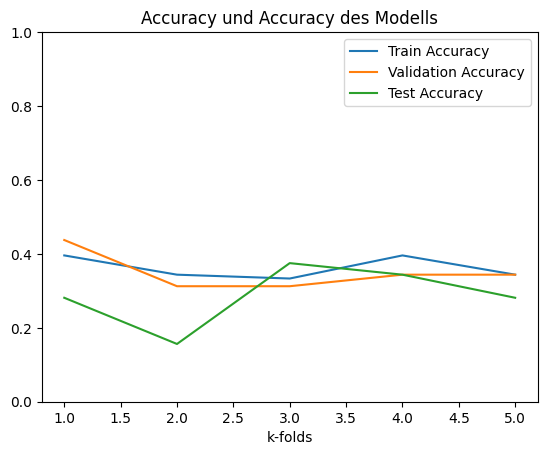

In [10]:
#auch noch zu überarbeiten
y_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.plot(range(1, k+1), accuracy_h)
plt.plot(range(1, k+1), val_accuracy_h)
plt.plot(range(1, k+1), eval_accuracy_h)
plt.title('Accuracy und Accuracy des Modells')
plt.xlabel('k-folds')
plt.yticks(y_ticks)
plt.gca().legend(('Train Accuracy', 'Validation Accuracy', 'Test Accuracy'))
plt.show()


Prediction

In [11]:
for j in range(len(prediction_h)):
    print(f"Model {j+1} ")
    print(f"Accuracy: {prediction_h[j]}%")

Model 1 
Accuracy: 28.12%
Model 2 
Accuracy: 15.62%
Model 3 
Accuracy: 37.5%
Model 4 
Accuracy: 34.38%
Model 5 
Accuracy: 28.12%
